<a href="https://colab.research.google.com/github/parth-6-5-4/Chat-GPT-clone/blob/main/Simple_MNIST_NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240627%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240627T072520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D405d9d3a59e4cbc03abf6aec0635b72f1aa55cef9fa5020a86db133c84312ee42942c6ee59897bb51d8017ca4ef78be7b9166d250a826564b39ab2ab6dd8d9b375dba723e0b3f88288ab2fc9349edcf3303bc793a073e8f9e98bf5be0d157118d1c5079c5503e32499d1749fb68f2cea0962ff337b8630b0eaa5c5c8ca9b901e7089f778966e3edb49cf7c6817d1664650a7b3cb7c30916ddd1c4d72ad9d29049788e0d8e1756b1583fdc4ca295c13210ba31858484720a5dafe2786532e3687734511e0c031f969d9a1c907d9d36b08ab2f57286b8e99b18efbc1b2040d6972c3d6b856cc0e359a6167317631e83ae3dab181b944c43334b37cc7ba94c1922d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


# Simple MNIST NN from scratch

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset.



In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [3]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [4]:
Y_train

array([3, 2, 2, ..., 3, 7, 7])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [5]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [6]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [20]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.20, 650)

Iteration:  0
[2 1 2 ... 4 4 7] [3 2 2 ... 3 7 7]
0.10439024390243902
Iteration:  10
[7 0 9 ... 3 5 7] [3 2 2 ... 3 7 7]
0.22846341463414635
Iteration:  20
[7 0 2 ... 3 2 7] [3 2 2 ... 3 7 7]
0.31521951219512195
Iteration:  30
[7 6 2 ... 8 6 7] [3 2 2 ... 3 7 7]
0.41165853658536583
Iteration:  40
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.48802439024390243
Iteration:  50
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.5487804878048781
Iteration:  60
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.5985853658536585
Iteration:  70
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.6413658536585366
Iteration:  80
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.673829268292683
Iteration:  90
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.6986585365853658
Iteration:  100
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.7203414634146341
Iteration:  110
[2 2 2 ... 3 6 7] [3 2 2 ... 3 7 7]
0.7401219512195122
Iteration:  120
[2 2 2 ... 3 9 7] [3 2 2 ... 3 7 7]
0.7537560975609756
Iteration:  130
[2 2 2 ... 3 9 7] [3 2 2 ... 3 7 7]
0.6892439024390243
Iteration:  1

~88% accuracy on training set.

In [17]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [3]
Label:  3


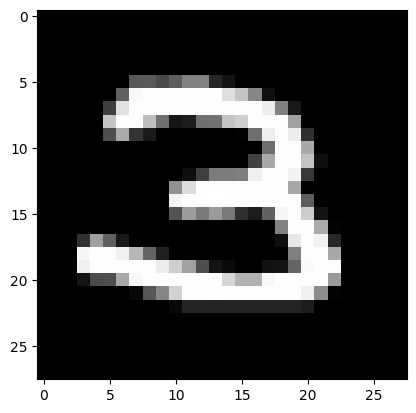

Prediction:  [2]
Label:  2


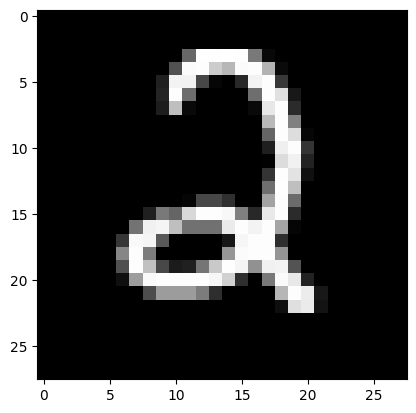

Prediction:  [2]
Label:  2


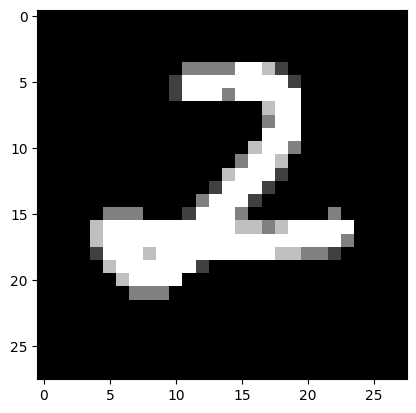

Prediction:  [4]
Label:  4


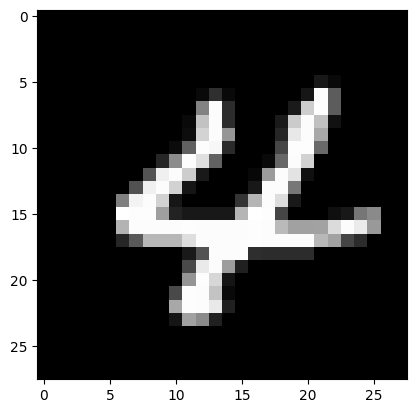

Prediction:  [7]
Label:  7


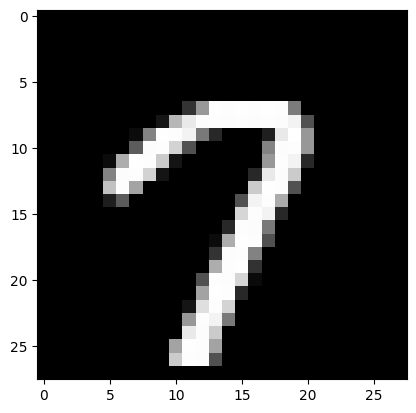

In [18]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(28, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [19]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[1 2 5 6 1 8 9 3 5 6 1 6 9 7 8 7 0 2 4 6 2 6 7 8 8 8 1 6 4 5 2 4 6 6 1 0 4
 0 6 2 1 0 1 7 8 2 5 0 6 1 4 9 4 2 7 1 3 8 2 6 3 1 9 4 6 4 1 3 7 0 8 3 1 4
 8 7 4 2 0 9 8 5 6 0 1 9 8 2 5 2 5 3 5 0 3 4 6 8 7 5 6 2 2 8 6 9 1 5 9 7 7
 2 0 6 8 6 6 4 7 6 4 4 9 7 3 5 7 6 0 8 6 1 9 5 1 2 7 8 2 8 7 1 8 5 8 1 0 4
 5 4 7 1 5 2 5 1 0 4 1 2 8 1 3 1 7 5 8 8 4 4 1 1 8 2 4 0 7 1 1 0 8 1 2 1 9
 4 4 1 7 2 3 5 4 2 7 8 4 1 8 0 5 5 6 2 5 5 2 4 6 1 8 5 1 0 9 5 7 9 5 2 3 7
 0 6 5 1 6 9 3 2 2 9 2 4 0 4 0 3 8 3 0 6 0 2 5 3 8 3 6 7 9 3 3 9 3 5 9 7 7
 0 2 4 6 6 4 4 2 0 5 4 0 8 8 6 8 3 3 8 4 1 6 7 0 9 7 7 7 3 0 8 0 4 1 0 9 5
 3 7 1 6 4 8 6 9 7 5 6 1 9 7 2 7 7 9 4 9 3 2 0 4 1 4 6 0 4 7 3 2 6 9 7 1 4
 4 0 5 0 2 7 7 7 5 4 0 9 5 1 4 5 8 8 2 0 9 7 2 5 4 0 4 8 1 8 6 6 6 0 9 2 0
 1 1 6 2 8 0 7 4 1 2 0 4 9 1 5 1 5 1 0 1 6 1 2 0 1 9 2 7 5 7 0 3 1 0 1 5 4
 8 4 0 3 9 6 3 5 9 7 6 8 0 6 1 9 3 7 7 2 7 2 3 3 5 9 8 1 5 0 1 2 2 5 3 5 1
 3 5 5 2 6 6 5 5 4 6 3 9 1 7 2 0 3 8 8 6 1 4 4 6 4 1 3 6 6 0 7 4 0 1 0 3 1
 6 2 7 3 0 1 1 2 4 9 4 6 

0.87

Still 87% accuracy, so our model generalized from the training data pretty well.